In [14]:
import pandas as pd
import pandas_datareader as web
from time import sleep
import os
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [42]:
# Get Stock of google for given dates 
df = web.DataReader('GOOGL',data_source='yahoo',start='2012-01-01',end='2020-09-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,334.409424,326.511505,326.796783,333.038025,7345600.0,333.038025
2012-01-04,335.460449,330.640656,332.847839,334.474487,5722200.0,334.474487
2012-01-05,332.317322,328.443451,331.396393,329.834839,6559200.0,329.834839
2012-01-06,330.330322,325.220215,329.904907,325.335327,5380400.0,325.335327
2012-01-09,323.823822,310.925934,323.573578,311.541534,11633500.0,311.541534
...,...,...,...,...,...,...
2020-08-26,1652.790039,1600.979980,1606.300049,1644.130005,2609400.0,1644.130005
2020-08-27,1647.989990,1618.810059,1646.609985,1628.520020,1567500.0,1628.520020
2020-08-28,1641.349976,1625.609985,1629.469971,1639.430054,1120900.0,1639.430054


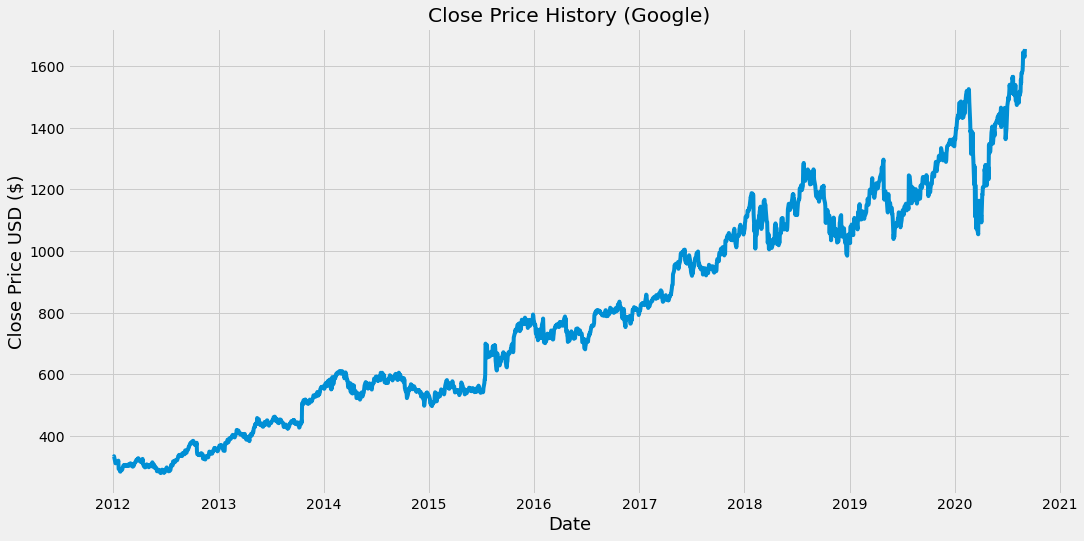

In [18]:
#plot the figure using data taken
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close Price History (Google)")
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [19]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [43]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [21]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [44]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [45]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [24]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1685/1685 [==============================] - 75s 45ms/step - loss: 4.6904e-04


In [48]:
#Creatinf a train data set
test_data = scaled_data[training_data_len - 60: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [49]:
x_test = np.array(x_test)

In [50]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [51]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [52]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

67.69575582723503

<ipython-input-53-950ef908bd9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions#Visualize the data


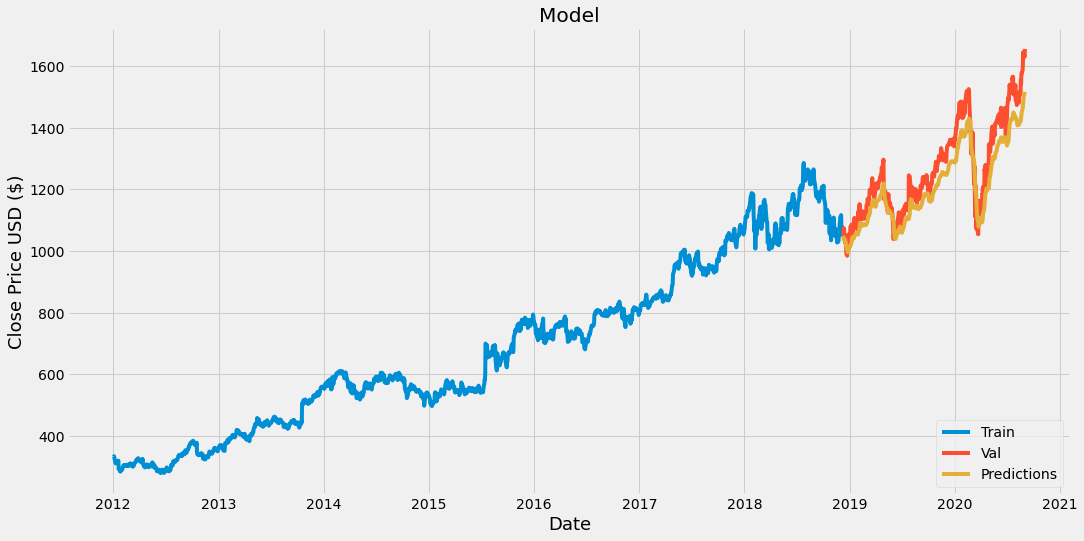

In [53]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [54]:
valid

,Close,Predictions
Date,,
2018-12-10,1053.180054,1049.282349
2018-12-11,1061.650024,1041.909668
2018-12-12,1073.729980,1037.247681
2018-12-13,1073.540039,1036.470947
2018-12-14,1051.709961,1037.457153
...,...,...
2020-08-26,1644.130005,1478.530151
2020-08-27,1628.520020,1493.057251
2020-08-28,1639.430054,1503.227905


In [55]:
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')#Create a new dataframe
new_df = apple_quote.filter(['Close'])#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)#Create an empty list
X_test = []#Append teh past 60 days
X_test.append(last_60_days_scaled)#Convert the X_test data set to a numpy array
X_test = np.array(X_test)#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))#Get the predicted scaled price
pred_price = model.predict(X_test)#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[92.65055]]


In [56]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-17    70.102501
2019-12-18    69.934998
Name: Close, dtype: float64


In [57]:
#done boi